In [111]:
using Plots, Polynomials

function lagrange(xs, ys, x)
    result = 0
    for i = xs
        t = ys[i]
        for j = xs
            if i != j
                t *= (x - xs[j]) / (xs[i] - xs[j])
            end
        end
        result += t
    end
    return result
end     

lagrange (generic function with 1 method)

  0.217664 seconds (186.30 k allocations: 8.701 MiB, 14.62% gc time)


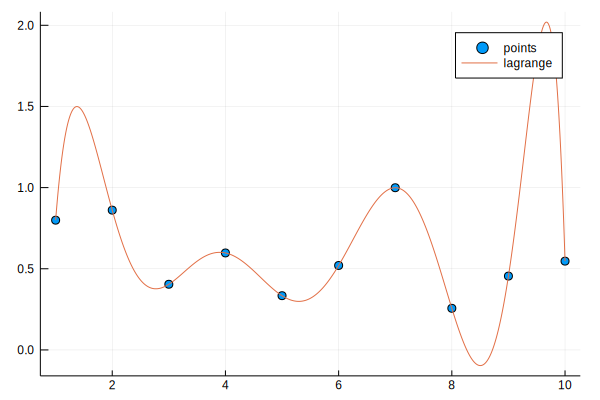

In [112]:
xs = 1:10
ys = rand(size(xs, 1))

l_xs = 1:0.01:10
@time l_ys = [lagrange(xs, ys, x) for x in l_xs]

scatter(xs, ys, label="points")
plot!(l_xs, l_ys, label="lagrange")

In [113]:
using Memoize

@memoize function div_diff(ys, xa, xb)
    if xa == xb
        return ys[xa]
    end
    
    return (div_diff(ys, xa + 1, xb) - div_diff(ys, xa, xb - 1)) / (xb - xa)
end

function div_table(ys)
    dt = zeros(size(ys, 1))
    for i = 1:size(ys, 1)
        dt[i] = div_diff(ys, 1, i)
    end
    return dt
end

function newton(dt, xs, ys, x)
    result = 0
    for i = 1:size(xs, 1)
        a = dt[i]
        t = 1
        if i == 1
            result += a
        else
            for j = 1:(i - 1)
                t *= x - xs[j]
            end
            result += a * t
        end
    end
    return result
end

newton (generic function with 1 method)

  0.129373 seconds (25.10 k allocations: 1.236 MiB)
  0.159240 seconds (210.24 k allocations: 9.985 MiB, 9.32% gc time)


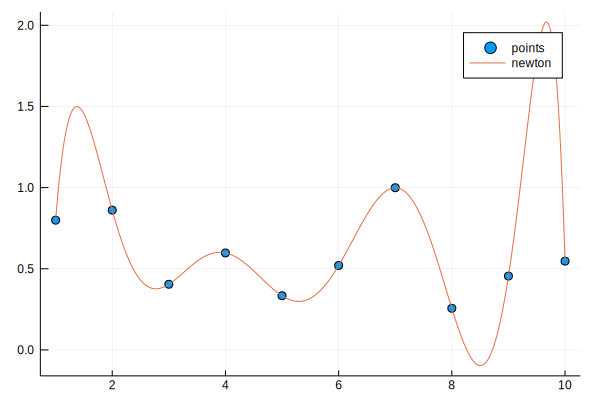

In [114]:
n_xs = 1:0.01:10
dt = div_table(ys)
@time n_ys = [newton(dt, xs, ys, x) for x in n_xs]

scatter(xs, ys, label="points")
plot!(n_xs, n_ys, label="newton")

  0.000191 seconds (23 allocations: 11.219 KiB)


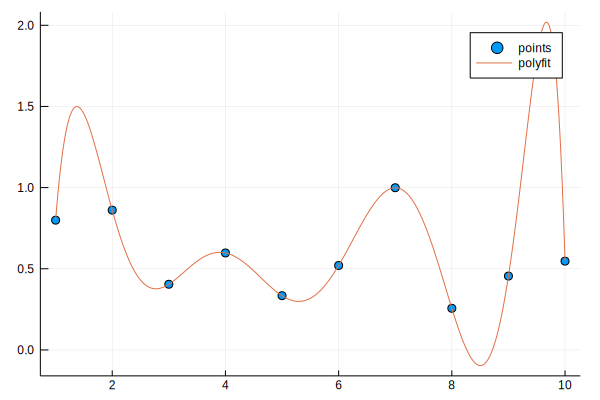

In [115]:
p_xs = 1:0.01:10
@time p_ys = [polyfit(xs, ys)(x) for x in p_xs]

scatter(xs, ys, label="points")
plot!(p_xs, p_ys, label="polyfit")

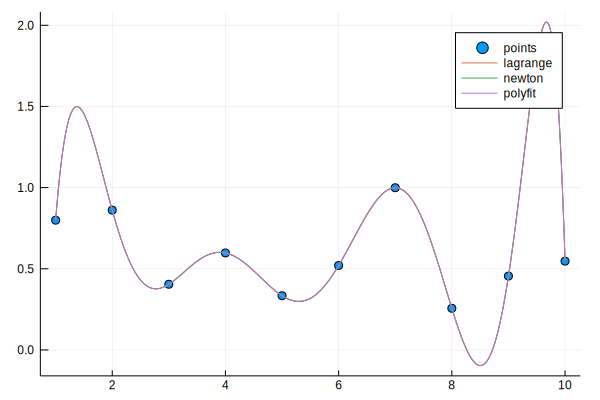

In [116]:
scatter(xs, ys, label="points")
plot!(l_xs, l_ys, label="lagrange")
plot!(n_xs, n_ys, label="newton")
plot!(p_xs, p_ys, label="polyfit")

In [117]:
using DataFrames

df1 = DataFrame(size=Int[], lagrange=Float64[], newton=Float64[], polyfit=Float64[])

for s = 10:5:200
    t_xs = 1:s
    t_ys = rand(size(t_xs, 1))
    t_dt = div_table(t_ys)
    t_fit = polyfit(t_xs, t_ys)
    for i = 1:11
        l = @elapsed [lagrange(t_xs, t_ys, x) for x in t_xs]
        n = @elapsed [newton(t_dt, t_xs, t_ys, x) for x in t_xs] 
        p = @elapsed [t_fit(x) for x in t_xs]
        
        if i > 1
            push!(df1, [s, l, n, p])
        end
    end
end

In [118]:
using Statistics

df2 = by(df1, :size,
    df->DataFrame(
        lagrange_mean=mean(df[:lagrange]), lagrange_std=std(df[:lagrange]),
        newton_mean=mean(df[:newton]), newton_std=std(df[:newton]),
        polyfit_mean=mean(df[:polyfit]), polyfit_std=std(df[:polyfit])
    )
)

,size,lagrange_mean,lagrange_std,newton_mean,newton_std,polyfit_mean,polyfit_std
,Int64,Float64,Float64,Float64,Float64,Float64,Float64
1,10,6.4284e-6,3.55526e-6,5.4655e-6,4.47277e-6,2.0343e-6,4.91599e-7
2,15,1.11586e-5,1.06177e-7,4.8525e-6,1.53717e-7,2.1144e-6,6.61618e-8
3,20,3.31788e-5,4.39944e-6,1.09758e-5,3.66514e-7,3.7503e-6,2.11438e-7
4,25,5.9923e-5,1.91024e-7,1.87404e-5,1.14908e-7,4.7014e-6,7.01272e-8
5,30,0.00011418,1.02665e-5,3.44123e-5,5.05638e-6,6.8369e-6,9.041e-7
6,35,0.00017744,1.27439e-5,5.51425e-5,7.62058e-6,1.08567e-5,2.55998e-6
7,40,0.000234909,5.79587e-6,6.6489e-5,6.28593e-6,8.4482e-6,1.75799e-7
8,45,0.000290206,7.43836e-6,8.36408e-5,3.53569e-6,9.7738e-6,2.86973e-7
9,50,0.000413841,2.09852e-6,0.00011301,2.82606e-6,1.14775e-5,3.50436e-7


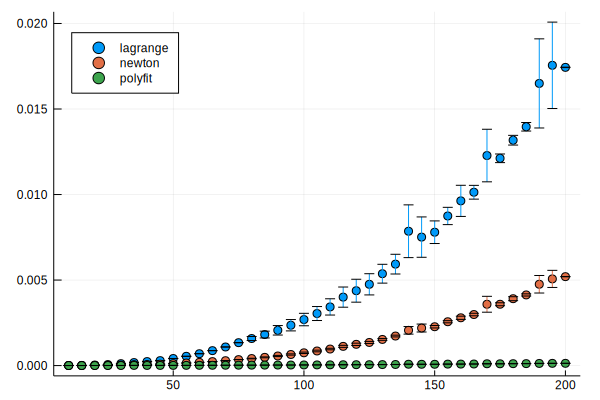

In [119]:
scatter(df2[:size],
    [df2[:lagrange_mean], df2[:newton_mean], df2[:polyfit_mean]],
    yerr=[df2[:lagrange_std] df2[:newton_std] df2[:polyfit_std]],
    label=["lagrange" "newton" "polyfit"], legend=:topleft
)

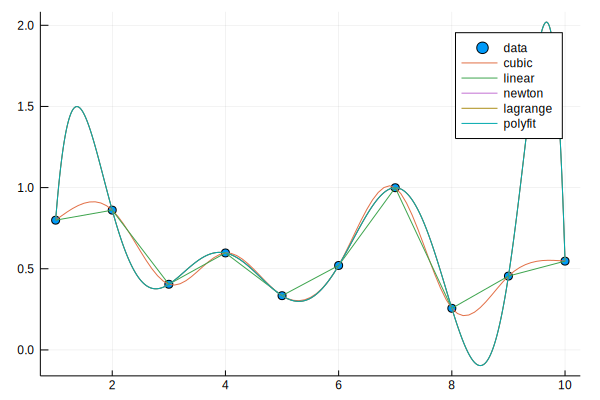

In [120]:
using Interpolations

cub_xs = 1:0.1:10
cub = CubicSplineInterpolation(xs, ys)
cub_ys = [cub(x) for x in cub_xs]

lin_xs = 1:0.1:10
lin = LinearInterpolation(xs, ys)
lin_ys = [lin(x) for x in lin_xs]

scatter(xs, ys, label="data")
plot!(cub_xs, cub_ys, label="cubic")
plot!(lin_xs, lin_ys, label="linear")
plot!(n_xs, n_ys, label="newton")
plot!(l_xs, l_ys, label="lagrange")
plot!(p_xs, p_ys, label="polyfit")